# README
This notebook is used to obtain the embeddings of the domain-knowledge prompt. Then, we can use the embeddings to cluster the samples with K-means.

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib as mpl
import pickle
import transformers
from matplotlib.lines import Line2D
import seaborn as sns
import json
import torch
from data_provider.data_split_recorder import split_recorder
from Prompts.Mapping_helper import Mapping_helper
from transformers import GPT2Config, GPT2Tokenizer, GPT2Model, AutoTokenizer, AutoModel, AutoConfig, Phi3Config

In [2]:
def set_ax_linewidth(ax, bw=1.5):
    ax.spines['bottom'].set_linewidth(bw)
    ax.spines['left'].set_linewidth(bw)
    ax.spines['top'].set_linewidth(bw)
    ax.spines['right'].set_linewidth(bw)

def set_ax_font_size(ax, fontsize=10):
    ax.tick_params(axis='y',
                 labelsize=fontsize # y轴字体大小设置
                  ) 
    ax.tick_params(axis='x',
                 labelsize=fontsize # x轴字体大小设置
                  ) 

def set_draft(the_plt, other_ax=''):
    ax = the_plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel('')
    plt.ylabel('')
    if other_ax:
        other_ax.axes.xaxis.set_ticklabels([])
        other_ax.axes.yaxis.set_ticklabels([])
        other_ax.set_ylabel('')
        other_ax.set_xlabel('')

def set_draft_fig(fig):
    for ax in fig.axes:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')

In [3]:
target_dataset = 'MIX_all42' # [MIX_large, MIX_all, MIX_all2024, MIX_all42]
if target_dataset == 'MIX_large':
    cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_large_train_files]
elif target_dataset == 'MIX_all':
    cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_2021_train_files]
elif target_dataset == 'MIX_all2024':
    cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_2024_train_files]
elif target_dataset == 'MIX_all42':
    cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_42_train_files]
cell_names

['UL-PUR_N10-NA7_18650_NCA_23C_0-100_0.5-0.5C_g',
 'UL-PUR_N15-NA10_18650_NCA_23C_0-100_0.5-0.5C_j',
 'RWTH_016',
 'RWTH_045',
 'RWTH_009',
 'RWTH_039',
 'RWTH_046',
 'RWTH_019',
 'RWTH_037',
 'RWTH_013',
 'RWTH_003',
 'RWTH_044',
 'RWTH_026',
 'RWTH_006',
 'RWTH_031',
 'RWTH_036',
 'RWTH_048',
 'RWTH_033',
 'RWTH_021',
 'RWTH_012',
 'RWTH_034',
 'RWTH_018',
 'RWTH_022',
 'RWTH_030',
 'RWTH_028',
 'RWTH_011',
 'RWTH_040',
 'RWTH_041',
 'RWTH_042',
 'RWTH_025',
 'RWTH_047',
 'RWTH_004',
 'HUST_1-6',
 'HUST_2-2',
 'HUST_1-3',
 'HUST_6-3',
 'HUST_1-2',
 'HUST_3-7',
 'HUST_3-2',
 'HUST_10-6',
 'HUST_3-6',
 'HUST_5-1',
 'HUST_10-5',
 'HUST_6-2',
 'HUST_6-1',
 'HUST_8-1',
 'HUST_10-7',
 'HUST_1-4',
 'HUST_5-4',
 'HUST_1-5',
 'HUST_6-6',
 'HUST_5-6',
 'HUST_6-4',
 'HUST_9-2',
 'HUST_10-4',
 'HUST_5-3',
 'HUST_7-7',
 'HUST_3-1',
 'HUST_4-1',
 'HUST_4-4',
 'HUST_4-6',
 'HUST_8-8',
 'HUST_2-4',
 'HUST_9-8',
 'HUST_9-5',
 'HUST_3-3',
 'HUST_1-7',
 'HUST_4-5',
 'HUST_9-6',
 'HUST_1-1',
 'HUST_4-3'

## Tokenize and embedding

In [4]:
def create_causal_mask(B, seq_len):
    '''
    return:
        casual mask: [B, L, L]. 0 indicates masked.
    '''
    # Create a lower triangular matrix of shape (seq_len, seq_len)
    mask = torch.tril(torch.ones(seq_len, seq_len))  # (L, L)
    mask = mask.unsqueeze(0).expand(B, -1, -1)
    return mask

In [5]:
# loader the tokenizer and model
# models--meta-llama--Llama-3.1-70B-Instruct
# /data/LLMs/models--meta-llama--Llama-3.3-70B-Instruct/snapshots/6f6073b423013f6a7d4d9f39144961bfbfbc386b
# /data/LLMs/models--meta-llama--Llama-3.1-70B-Instruct/snapshots/945c8663693130f8be2ee66210e062158b2a9693
# '/data/LLMs/models--meta-llama--Llama-3.1-8B-Instruct/snapshots/0e9e39f249a16976918f6564b8830bc894c89659'
# /data/LLMs/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95
# /data/LLMs/models--openai-community--gpt2-large/snapshots/32b71b12589c2f8d625668d2335a01cac3249519
LLM_path = '/data/LLMs/models--meta-llama--Llama-3.1-8B-Instruct/snapshots/0e9e39f249a16976918f6564b8830bc894c89659'
llama_config = AutoConfig.from_pretrained(LLM_path)
language_model = AutoModel.from_pretrained(
            LLM_path,
            # 'huggyllama/llama-7b',
            trust_remote_code=True,
            local_files_only=True,
            config=llama_config,
            load_in_4bit=True
        )
tokenizer = AutoTokenizer.from_pretrained(
                LLM_path,
                # 'huggyllama/llama-7b',
                trust_remote_code=True,
                local_files_only=True, 
                pad_token='<|endoftext|>'
            )
tokenizer.padding_side = 'right' # set the padding side

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
def read_cell_data_according_to_prefix(file_name, root_path):
    prefix = file_name.split('_')[0]
    if prefix == 'MICH':
        with open(f'{root_path}/Life labels/total_MICH_labels.json') as f:
            life_labels = json.load(f)
    elif prefix.startswith('Tongji'):
        file_name = file_name.replace('--', '-#')
        with open(f'{root_path}/Life labels/Tongji_labels.json') as f:
            life_labels = json.load(f)
    else:
        with open(f'{root_path}/Life labels/{prefix}_labels.json') as f:
            life_labels = json.load(f)
    if file_name in life_labels:
        eol = life_labels[file_name]
    else:
        eol = None

    return eol

def get_features_from_cellNames(cell_names):
    cellName_prompt = {}
    total_labels = []
    for cell_name in cell_names:
        bg_prompt = (
                    f"Task description: You are an expert in predicting battery cycle life. " 
                    f"The cycle life is the number of cycles until the battery's discharge capacity reaches 80% of its nominal capacity. "
                    f"The discharge capacity is calculated under the described operating condition. "
                    f"Please directly output the cycle life of the battery based on the provided data. "
                    )
        helper = Mapping_helper(prompt_type='PROTOCOL', cell_name=cell_name)
        tmp_prompt = bg_prompt + helper.do_mapping()
        eol = read_cell_data_according_to_prefix(cell_name+'.pkl', '/data/trf/python_works/BatteryLife/dataset')
        if eol is None:
            print(cell_name+'.pkl')
            continue
        total_labels.append(eol)
        # Llama-instruct
        if 'models--openai-community--gpt2-large' in LLM_path:
            pass
        else:
            messages = [
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": tmp_prompt}
            ]

            tmp_prompt = tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=False
            )

        res = tokenizer(tmp_prompt, return_tensors="pt")
        input_ids, attention_mask = res['input_ids'][:,1:], res['attention_mask'][:,1:]
        llama_enc_out = language_model.get_input_embeddings()(input_ids) # [1, L', d_llm]
        
        cache_position = torch.arange(
                0, 0 + llama_enc_out.shape[1], device=llama_enc_out.device
            )
        position_ids = cache_position.unsqueeze(0)
        DLP_attention_mask = attention_mask.unsqueeze(1) # [B, 1, L]
        DLP_attention_mask = DLP_attention_mask.expand(-1, DLP_attention_mask.shape[-1], -1) # [B, L, L]
        DLP_attention_mask = DLP_attention_mask.unsqueeze(1) # [B, 1, L, L]
        
        casual_mask = create_causal_mask(1, llama_enc_out.shape[1])
        casual_mask = casual_mask.unsqueeze(1) # [B, 1, L, L]

        DLP_attention_mask = torch.where(casual_mask.to(DLP_attention_mask.device)==1, DLP_attention_mask, torch.zeros_like(DLP_attention_mask))
        DLP_attention_mask = DLP_attention_mask==1 # set True to allow attention to attend to

        hidden_states = language_model(inputs_embeds=llama_enc_out).last_hidden_state
        # hidden_states = llama_enc_out
        # for i, layer in enumerate(language_model.layers):
        #     res = layer(hidden_states=hidden_states, position_ids=position_ids, attention_mask=DLP_attention_mask, cache_position=cache_position)
        #     hidden_states = res[0]

        features = hidden_states[:,-1,:].detach().cpu().numpy().reshape(1, -1)
        
        cellName_prompt[cell_name] = features
    return cellName_prompt, total_labels

cellName_prompt, total_labels = get_features_from_cellNames(cell_names)

# get the features from validation and testing sets
if target_dataset == 'MIX_large':
    val_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_large_val_files]
    test_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_large_test_files]
elif target_dataset == 'MIX_all':
    val_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_2021_val_files]
    test_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_2021_test_files]
elif target_dataset == 'MIX_all2024':
    val_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_2024_val_files]
    test_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_2024_test_files]
elif target_dataset == 'MIX_all42':
    val_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_42_val_files]
    test_cell_names = [i.split('.pkl')[0] for i in split_recorder.MIX_all_42_test_files]
val_cellName_prompt, val_total_labels = get_features_from_cellNames(val_cell_names)
test_cellName_prompt, test_total_labels = get_features_from_cellNames(test_cell_names)



We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
/home/trf/envs/llmpy311/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:435: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


MICH_18H_pouch_NMC_45C_50-100_0.2-1.5C.pkl
MICH_17C_pouch_NMC_-5C_50-100_0.2-1.5C.pkl
MICH_15H_pouch_NMC_45C_50-100_0.2-0.2C.pkl
MICH_13R_pouch_NMC_25C_50-100_0.2-0.2C.pkl
MICH_14C_pouch_NMC_-5C_50-100_0.2-0.2C.pkl
ZN-coin_410-1_20231209232559_09_1.pkl
ZN-coin_428-2_20231212185058_01_4.pkl
ZN-coin_418-1_20231209234141_11_1.pkl
MICH_16R_pouch_NMC_25C_50-100_0.2-1.5C.pkl
ZN-coin_403-1_20231209225922_01_4.pkl
ZN-coin_402-1_20231209225636_01_1.pkl


## Visualize the embeddings

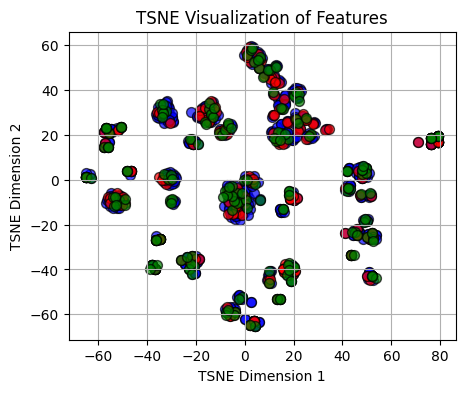

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
total_features = []
names = []
for name, feature in cellName_prompt.items():
    name = name.split('_')[0]
    names.append(name)
    total_features.append(feature)


val_total_features = []
val_names = []
for name, feature in val_cellName_prompt.items():
    name = name.split('_')[0]
    val_names.append(name)
    val_total_features.append(feature)

test_total_features = []
test_names = []
for name, feature in test_cellName_prompt.items():
    name = name.split('_')[0]
    test_names.append(name)
    test_total_features.append(feature)

concated_features = np.concatenate(total_features+val_total_features+test_total_features, axis=0)

train_split = len(cellName_prompt)
val_split = train_split + len(val_cellName_prompt)

total_features = np.concatenate(total_features, axis=0)
# Perform TSNE to project the features to 2D
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(concated_features)

# Visualize the TSNE projection
plt.figure(figsize=(5, 4))
plt.scatter(X_embedded[:train_split, 0], X_embedded[:train_split, 1], c='blue', alpha=0.7, edgecolors='k', s=50)
plt.scatter(X_embedded[train_split:val_split, 0], X_embedded[train_split:val_split, 1], c='red', alpha=0.7, edgecolors='k', s=50)
plt.scatter(X_embedded[val_split:, 0], X_embedded[val_split:, 1], c='green', alpha=0.7, edgecolors='k', s=50)
# # Add names to points (optional, if the dataset is small)
# for i, name in enumerate(names):
#     plt.text(X_embedded[i, 0] + 0.2, X_embedded[i, 1], name, fontsize=8)

plt.title("TSNE Visualization of Features")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
plt.grid(True)
plt.savefig('./figures/t-SNE_train-val-test.jpg', dpi=600)
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.37720185332108
For n_clusters = 3 The average silhouette_score is : 0.3597257351519643
For n_clusters = 4 The average silhouette_score is : 0.3422431360882718
For n_clusters = 5 The average silhouette_score is : 0.31964519913504974
For n_clusters = 6 The average silhouette_score is : 0.37297012010280906
For n_clusters = 7 The average silhouette_score is : 0.4221452541543621
For n_clusters = 8 The average silhouette_score is : 0.4123652485901017
For n_clusters = 9 The average silhouette_score is : 0.4467268429967113
For n_clusters = 10 The average silhouette_score is : 0.47825171089716595
For n_clusters = 11 The average silhouette_score is : 0.49097474112940936
For n_clusters = 12 The average silhouette_score is : 0.5170357595757112
For n_clusters = 13 The average silhouette_score is : 0.5254580083481237
For n_clusters = 14 The average silhouette_score is : 0.5411769971043136
For n_clusters = 15 The average silhouette_score is : 0.5

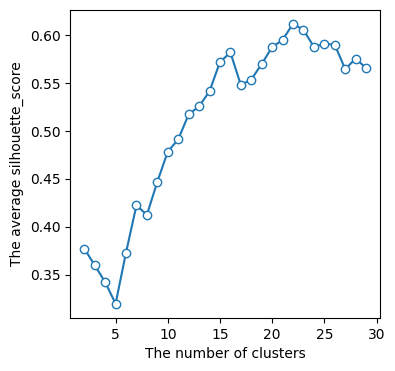

[(22, 0.6116096234052116),
 (23, 0.605231276635777),
 (21, 0.5946695635950029),
 (25, 0.5907750617484001),
 (26, 0.5897699861157196),
 (24, 0.5875143501401415),
 (20, 0.5872337569603784),
 (16, 0.5816430006806657),
 (28, 0.5752930327529446),
 (15, 0.5716689001279079),
 (19, 0.5696423004326779),
 (29, 0.5653873342997116),
 (27, 0.5641861866591312),
 (18, 0.5533973190268753),
 (17, 0.5477470555881621),
 (14, 0.5411769971043136),
 (13, 0.5254580083481237),
 (12, 0.5170357595757112),
 (11, 0.49097474112940936),
 (10, 0.47825171089716595),
 (9, 0.4467268429967113),
 (7, 0.4221452541543621),
 (8, 0.4123652485901017),
 (2, 0.37720185332108),
 (6, 0.37297012010280906),
 (3, 0.3597257351519643),
 (4, 0.3422431360882718),
 (5, 0.31964519913504974)]

In [8]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score


X = total_features
range_n_clusters = list(range(2,30))
total_scores = []
for n_clusters in range_n_clusters:


    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    total_scores.append(silhouette_avg)

fig = plt.figure(figsize=(4, 4))
plt.plot(range_n_clusters, total_scores, marker='o', markerfacecolor='white')
plt.xlabel('The number of clusters')
plt.ylabel('The average silhouette_score')
plt.show()

n_cluster_scores = dict(zip(range_n_clusters, total_scores))
n_cluster_scores = sorted(n_cluster_scores.items(), key= lambda x:x[1], reverse=True)
n_cluster_scores

## Cluster and visualize
We cluster the samples using K-Means and visualize the clusters

Best K is 5
['CALB', 'Tongji3', 'NA-ion', 'ZN-coin', 'Tongji2', 'ISU-ILCC', 'XJTU', 'HUST', 'CALCE', 'HNEI', 'Stanford', 'SNL', 'MATR', 'UL-PUR', 'Tongji1', 'MICH', 'RWTH']


/tmp/ipykernel_2054964/455548991.py:42: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tsne_results[i, 0], tsne_results[i, 1],
/tmp/ipykernel_2054964/455548991.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('4').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tsne_results[i, 0], tsne_results[i, 1],
/tmp/ipykernel_2054964/455548991.py:42: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('3').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(tsne_results[i, 0], tsne_results[i, 1],
/tmp/ipykernel_2054964/455548991.py:47: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('3').  Matplotlib is ignoring the 

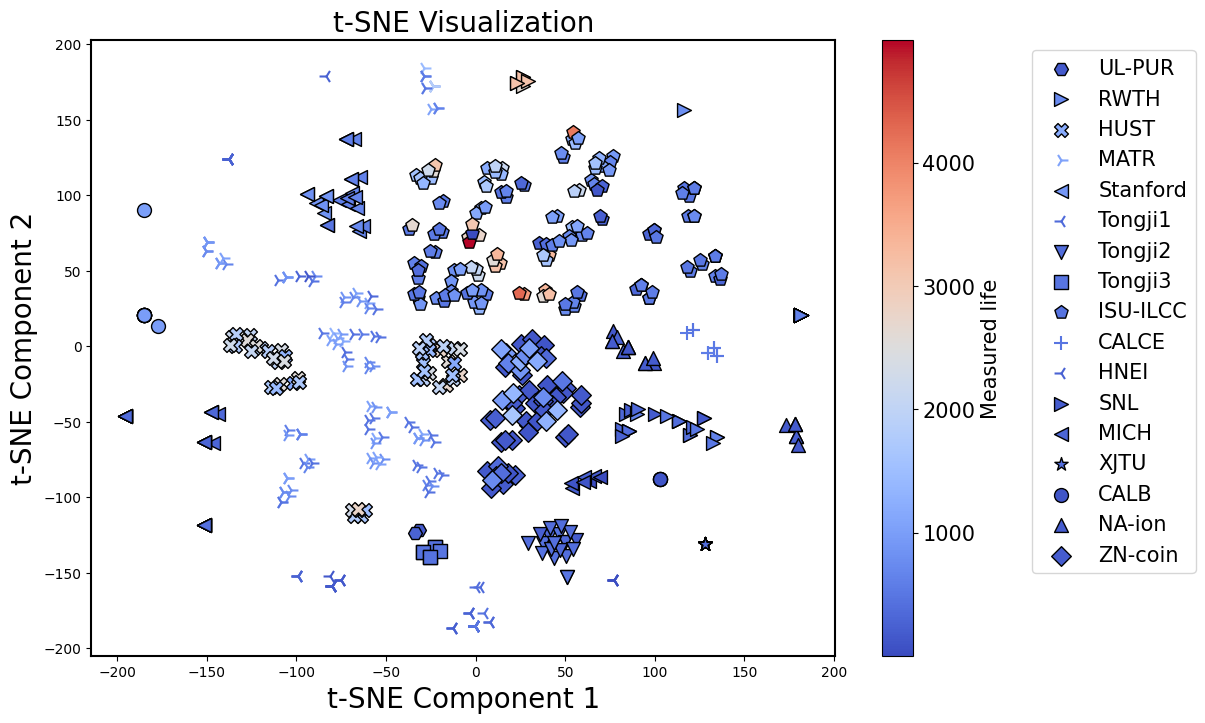

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

total_labels = np.array(total_labels)
tmp_total_features = total_features
tmp_total_labels = total_labels
norm = mpl.colors.Normalize(vmin=min(tmp_total_labels), vmax=max(tmp_total_labels))
tmp_total_labels = tmp_total_labels.reshape(-1, 1)
tmp_total_labels = scaler.fit_transform(tmp_total_labels).reshape(-1)

# Use the K that has the highest score
set_n_clusters = n_cluster_scores[0][0]
set_n_clusters = 5

print(f'Best K is {set_n_clusters}')
k_means = KMeans(n_clusters=n_cluster_scores[0][0], random_state=5)
cluster_labels = k_means.fit_predict(tmp_total_features)
cluster_centers = k_means.cluster_centers_ # [set_n_clusters, d_llm]

# Perform t-SNE on the embeddings (total_features)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # Reduce to 2D for visualization
tsne_results = tsne.fit_transform(tmp_total_features)
dataset_names = names

plt.figure(figsize=(12, 8))
# Define a list of different shapes for the clusters
dataset_shapes = ['o', 's', '^', 'D', 'v', 'p', '*', 'X', '+', '3', '<', '>', '4', 'H','3', '<', '>', '4', 'H']
unique_datasets = list(set(dataset_names))
dataset_shape_map = dict(zip(unique_datasets, dataset_shapes))
print(unique_datasets)
# Define a list of different colors for the datasets
# We'll use a set to get unique dataset names, and then assign a color to each dataset
unique_cluster_labels = list(set(cluster_labels))
colormap =  mpl.colormaps['coolwarm']
# # Map each unique dataset name to a color
# cluster_color_map = {name: colors[i] for i, name in enumerate(unique_cluster_labels)}

# Plot each point with its corresponding cluster label and dataset shape
appear_datasetNames = []
for i in range(len(tmp_total_features)):
    if dataset_names[i] not in appear_datasetNames:
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1],
                    c=[colormap(tmp_total_labels[i])],  # Color by cluster label
                    marker=dataset_shape_map[dataset_names[i]],  # Shape by dataset name
                     s=100, edgecolor='k', label=dataset_names[i])
    else:
        plt.scatter(tsne_results[i, 0], tsne_results[i, 1],
                    c=[colormap(tmp_total_labels[i])],  # Color by cluster label
                    marker=dataset_shape_map[dataset_names[i]],  # Shape by dataset name
                    s=100, edgecolor='k')
    appear_datasetNames.append(dataset_names[i])

# Add labels and title
plt.title("t-SNE Visualization", fontsize=20)
plt.xlabel("t-SNE Component 1", fontsize=20)
plt.ylabel("t-SNE Component 2", fontsize=20)

# Custom legend for cluster shapes only (no color distinction)
legend_shapes = [Line2D([0], [0], marker=shape, color='w', markerfacecolor='k', markersize=15) for shape in dataset_shapes]
# plt.legend(dataset_shapes, unique_datasets, title="Datasets", loc='upper right')
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colormap), ax=plt.gca())
cb.ax.tick_params(labelsize=15)
cb.set_label('Measured life', fontsize=15)
plt.legend(loc='upper left', bbox_to_anchor=(1.25, 1), fontsize=15)
# plt.xlim(-300, 250)
# plt.ylim(-210, 300)
set_ax_linewidth(plt.gca())
fig.tight_layout()
plt.savefig('./figures/t-SNE_clustering.jpg', dpi=600, bbox_inches='tight')
plt.show()

## Save the results

In [10]:
## Export the clustering results
cluster_labels = [int(i) for i in cluster_labels]
cellNames_ClusterLabels = dict(zip(list(cellName_prompt.keys()), cluster_labels))
print(cell_names)
index_clusterCenters = {}
for i in range(set_n_clusters):
    index_clusterCenters[i] = cluster_centers[i]

print(index_clusterCenters)

['UL-PUR_N10-NA7_18650_NCA_23C_0-100_0.5-0.5C_g', 'UL-PUR_N15-NA10_18650_NCA_23C_0-100_0.5-0.5C_j', 'RWTH_016', 'RWTH_045', 'RWTH_009', 'RWTH_039', 'RWTH_046', 'RWTH_019', 'RWTH_037', 'RWTH_013', 'RWTH_003', 'RWTH_044', 'RWTH_026', 'RWTH_006', 'RWTH_031', 'RWTH_036', 'RWTH_048', 'RWTH_033', 'RWTH_021', 'RWTH_012', 'RWTH_034', 'RWTH_018', 'RWTH_022', 'RWTH_030', 'RWTH_028', 'RWTH_011', 'RWTH_040', 'RWTH_041', 'RWTH_042', 'RWTH_025', 'RWTH_047', 'RWTH_004', 'HUST_1-6', 'HUST_2-2', 'HUST_1-3', 'HUST_6-3', 'HUST_1-2', 'HUST_3-7', 'HUST_3-2', 'HUST_10-6', 'HUST_3-6', 'HUST_5-1', 'HUST_10-5', 'HUST_6-2', 'HUST_6-1', 'HUST_8-1', 'HUST_10-7', 'HUST_1-4', 'HUST_5-4', 'HUST_1-5', 'HUST_6-6', 'HUST_5-6', 'HUST_6-4', 'HUST_9-2', 'HUST_10-4', 'HUST_5-3', 'HUST_7-7', 'HUST_3-1', 'HUST_4-1', 'HUST_4-4', 'HUST_4-6', 'HUST_8-8', 'HUST_2-4', 'HUST_9-8', 'HUST_9-5', 'HUST_3-3', 'HUST_1-7', 'HUST_4-5', 'HUST_9-6', 'HUST_1-1', 'HUST_4-3', 'HUST_2-5', 'HUST_4-7', 'HUST_7-2', 'HUST_8-4', 'HUST_3-5', 'HUST_2-

In [11]:
## Export the domain-knowledge prompt embeddings of the samples
save_path = '/data/trf/python_works/BatteryLife/dataset/'
print(len(cell_names))
print(len(cluster_labels))
print(len(cellNames_ClusterLabels))
for key,value in cellNames_ClusterLabels.items():
    print(key, value)

if target_dataset == 'MIX_large':
    with open(f'{save_path}cellNames_ClusterLabels.json', 'w') as f:
        json.dump(cellNames_ClusterLabels, f)
    with open(f'{save_path}training_DKP_embed.pkl', 'wb') as f:
        pickle.dump(cellName_prompt, f)
    with open(f'{save_path}validation_DKP_embed.pkl', 'wb') as f:
        pickle.dump(val_cellName_prompt, f)
    with open(f'{save_path}testing_DKP_embed.pkl', 'wb') as f:
        pickle.dump(test_cellName_prompt, f)
elif target_dataset == 'MIX_all':
    with open(f'{save_path}cellNames_ClusterLabels_all.json', 'w') as f:
        json.dump(cellNames_ClusterLabels, f)
    with open(f'{save_path}training_DKP_embed_all.pkl', 'wb') as f:
        pickle.dump(cellName_prompt, f)
    with open(f'{save_path}validation_DKP_embed_all.pkl', 'wb') as f:
        pickle.dump(val_cellName_prompt, f)
    with open(f'{save_path}testing_DKP_embed_all.pkl', 'wb') as f:
        pickle.dump(test_cellName_prompt, f)
elif target_dataset == 'MIX_all2024':
    with open(f'{save_path}cellNames_ClusterLabels_all2024.json', 'w') as f:
        json.dump(cellNames_ClusterLabels, f)
    with open(f'{save_path}training_DKP_embed_all2024.pkl', 'wb') as f:
        pickle.dump(cellName_prompt, f)
    with open(f'{save_path}validation_DKP_embed_all2024.pkl', 'wb') as f:
        pickle.dump(val_cellName_prompt, f)
    with open(f'{save_path}testing_DKP_embed_all2024.pkl', 'wb') as f:
        pickle.dump(test_cellName_prompt, f)
elif target_dataset == 'MIX_all42':
    with open(f'{save_path}cellNames_ClusterLabels_all42.json', 'w') as f:
        json.dump(cellNames_ClusterLabels, f)
    with open(f'{save_path}training_DKP_embed_all42.pkl', 'wb') as f:
        pickle.dump(cellName_prompt, f)
    with open(f'{save_path}validation_DKP_embed_all42.pkl', 'wb') as f:
        pickle.dump(val_cellName_prompt, f)
    with open(f'{save_path}testing_DKP_embed_all42.pkl', 'wb') as f:
        pickle.dump(test_cellName_prompt, f)

612
605
605
UL-PUR_N10-NA7_18650_NCA_23C_0-100_0.5-0.5C_g 3
UL-PUR_N15-NA10_18650_NCA_23C_0-100_0.5-0.5C_j 3
RWTH_016 11
RWTH_045 11
RWTH_009 11
RWTH_039 11
RWTH_046 11
RWTH_019 11
RWTH_037 11
RWTH_013 11
RWTH_003 11
RWTH_044 11
RWTH_026 11
RWTH_006 11
RWTH_031 11
RWTH_036 11
RWTH_048 11
RWTH_033 11
RWTH_021 11
RWTH_012 11
RWTH_034 11
RWTH_018 11
RWTH_022 11
RWTH_030 11
RWTH_028 11
RWTH_011 11
RWTH_040 11
RWTH_041 11
RWTH_042 11
RWTH_025 11
RWTH_047 11
RWTH_004 11
HUST_1-6 13
HUST_2-2 5
HUST_1-3 5
HUST_6-3 13
HUST_1-2 5
HUST_3-7 13
HUST_3-2 5
HUST_10-6 13
HUST_3-6 13
HUST_5-1 5
HUST_10-5 5
HUST_6-2 13
HUST_6-1 21
HUST_8-1 13
HUST_10-7 13
HUST_1-4 5
HUST_5-4 13
HUST_1-5 5
HUST_6-6 13
HUST_5-6 13
HUST_6-4 21
HUST_9-2 13
HUST_10-4 13
HUST_5-3 5
HUST_7-7 5
HUST_3-1 5
HUST_4-1 21
HUST_4-4 5
HUST_4-6 5
HUST_8-8 13
HUST_2-4 5
HUST_9-8 5
HUST_9-5 13
HUST_3-3 13
HUST_1-7 13
HUST_4-5 5
HUST_9-6 5
HUST_1-1 21
HUST_4-3 5
HUST_2-5 13
HUST_4-7 13
HUST_7-2 13
HUST_8-4 5
HUST_3-5 21
HUST_2-6 5
HUST_8-

In [ ]:
cccc = pickle.load(open(f'{save_path}training_DKP_embed_all.pkl', 'rb'))


array([[ 2.172,  2.941,  0.483, ..., -1.632,  0.971,  2.17 ]],
      dtype=float16)